# Intel Stock Price (INTC) Forecasting -- RNN

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

In [ ]:
#pip show tensorflow

import pkg_resources

try:
    tensorflow_version = pkg_resources.get_distribution("tensorflow").version
    print("TensorFlow Version:", tensorflow_version)
except pkg_resources.DistributionNotFound:
    print("TensorFlow is not installed")


TensorFlow Version: 2.11.1


In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.optimizers import SGD, Adam
from keras import layers

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE


In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
df = pd.read_csv('INTC.csv')
data = df.copy()
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,41.632813,43.687500,41.625000,43.500000,25.214338,57710200
1,2000-01-04,42.718750,43.937500,41.125000,41.468750,24.036938,51019600
2,2000-01-05,41.500000,42.937500,40.250000,41.812500,24.236191,52389000
3,2000-01-06,40.875000,41.687500,39.093750,39.375000,22.823311,55171200
4,2000-01-07,38.750000,41.000000,38.687500,41.000000,23.765236,41096400
...,...,...,...,...,...,...,...
5885,2023-05-24,29.309999,29.490000,28.820000,29.000000,29.000000,28045800
5886,2023-05-25,28.290001,28.290001,26.860001,27.400000,27.400000,78009400
5887,2023-05-26,27.440001,29.090000,27.100000,29.000000,29.000000,71879700
5888,2023-05-30,29.700001,30.040001,29.000000,29.990000,29.990000,54874800


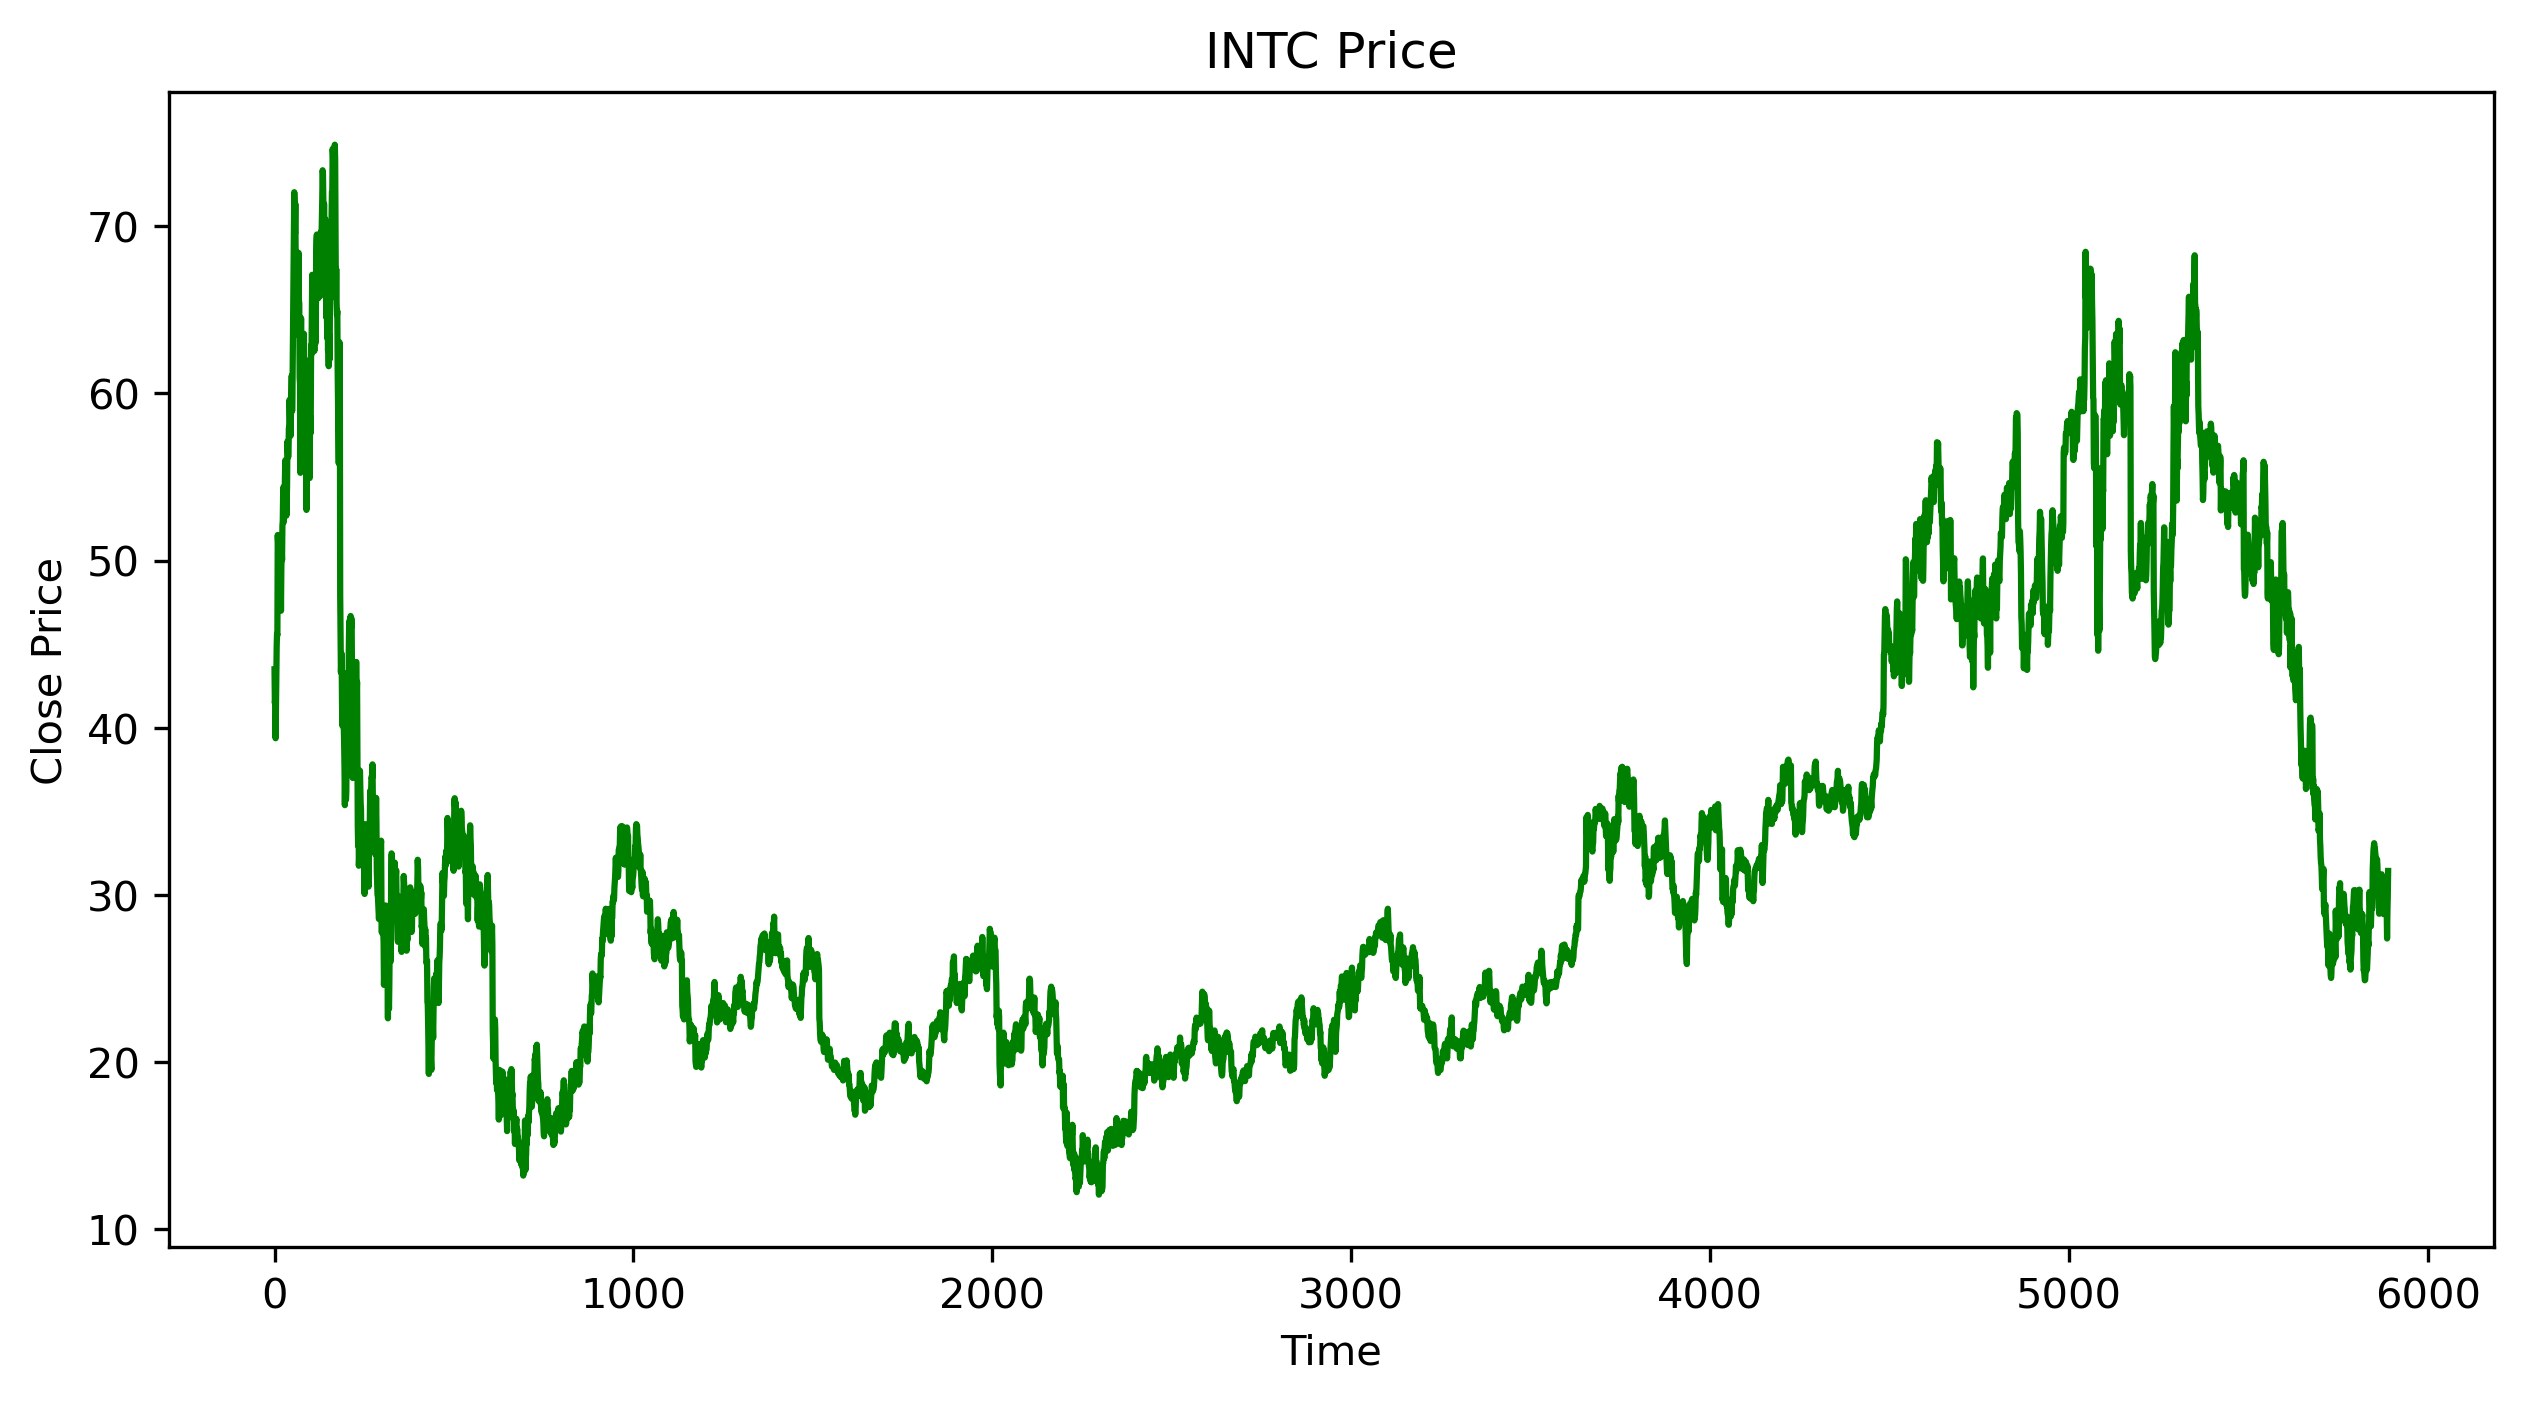

In [ ]:
data=data['Close']
plt.figure(figsize=(10,5),dpi=300)
plt.plot(data, color ='green');
plt.ylabel('Close Price')
plt.title('INTC Price')
plt.xlabel('Time')
plt.show()

In [ ]:

split =int(0.8*data.shape[0])
Train,Test  = data[0:split] , data[split:]

val_split=int(0.8*Train.shape[0])
Train,Val=Train[0:val_split] , Train[val_split:]
Val=Val.reset_index(drop=True)
#Test=Test.reset_index(drop=True)


In [ ]:
Test

4712    45.910000
4713    45.700001
4714    45.880001
4715    47.290001
4716    46.450001
          ...    
5885    29.000000
5886    27.400000
5887    29.000000
5888    29.990000
5889    31.440001
Name: Close, Length: 1178, dtype: float64

In [ ]:
Test=Test.reset_index(drop=True)
Test

0       45.910000
1       45.700001
2       45.880001
3       47.290001
4       46.450001
          ...    
1173    29.000000
1174    27.400000
1175    29.000000
1176    29.990000
1177    31.440001
Name: Close, Length: 1178, dtype: float64

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
#需將資料做reshape的動作，使其shape為(資料長度,1)
train_set= Train.values.reshape(-1,1)
training_set_scaled = sc.fit_transform(train_set)
val_set= Val.values.reshape(-1,1)
val_set_scaled = sc.transform(val_set)
test_set = Test.values.reshape(-1,1)
test_set_scaled = sc.transform(test_set)

X_train = []
y_train = []
for i in range(5,len(train_set)):
    X_train.append(training_set_scaled[i-5:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

X_val = []
y_val = []
for i in range(5,len(val_set)):
    X_val.append(val_set_scaled[i-5:i])
    y_val.append(val_set_scaled[i])
X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val,(X_val.shape[0], X_val.shape[1], 1))

X_test = []
y_test = []
for i in range(5,len(test_set)):
    X_test.append(test_set_scaled[i-5:i]) #更改過
    y_test.append(test_set_scaled[i])#同上
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_train[0]

array([[0.50035831],
       [0.46801099],
       [0.47348515],
       [0.43466837],
       [0.46054622]])

# Fit & compile the model

In [ ]:
keras.backend.clear_session()
model = keras.models.Sequential([
    GRU(32, input_shape=(X_train.shape[1], 1)),
    Dense(1)
]) #改LSTM等等 如 GRU，LSTM
opt=Adam(learning_rate=0.002,beta_1=0.95)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_val,y_val))

Epoch 1/100
118/118 [==============================] - 1s 3ms/step - loss: 0.0030 - val_loss: 1.7181e-04
Epoch 2/100
118/118 [==============================] - 0s 1ms/step - loss: 2.3879e-04 - val_loss: 1.3659e-04
Epoch 3/100
118/118 [==============================] - 0s 1ms/step - loss: 2.3124e-04 - val_loss: 1.3057e-04
Epoch 4/100
118/118 [==============================] - 0s 1ms/step - loss: 2.2920e-04 - val_loss: 1.5499e-04
Epoch 5/100
118/118 [==============================] - 0s 1ms/step - loss: 2.1838e-04 - val_loss: 1.6606e-04
Epoch 6/100
118/118 [==============================] - 0s 1ms/step - loss: 2.0973e-04 - val_loss: 1.1714e-04
Epoch 7/100
118/118 [==============================] - 0s 1ms/step - loss: 1.9828e-04 - val_loss: 1.3949e-04
Epoch 8/100
118/118 [==============================] - 0s 1ms/step - loss: 2.0254e-04 - val_loss: 2.2449e-04
Epoch 9/100
118/118 [==============================] - 0s 1ms/step - loss: 2.0886e-04 - val_loss: 1.0731e-04
Epoch 10/100
118/118 [=

In [ ]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'val_loss'])

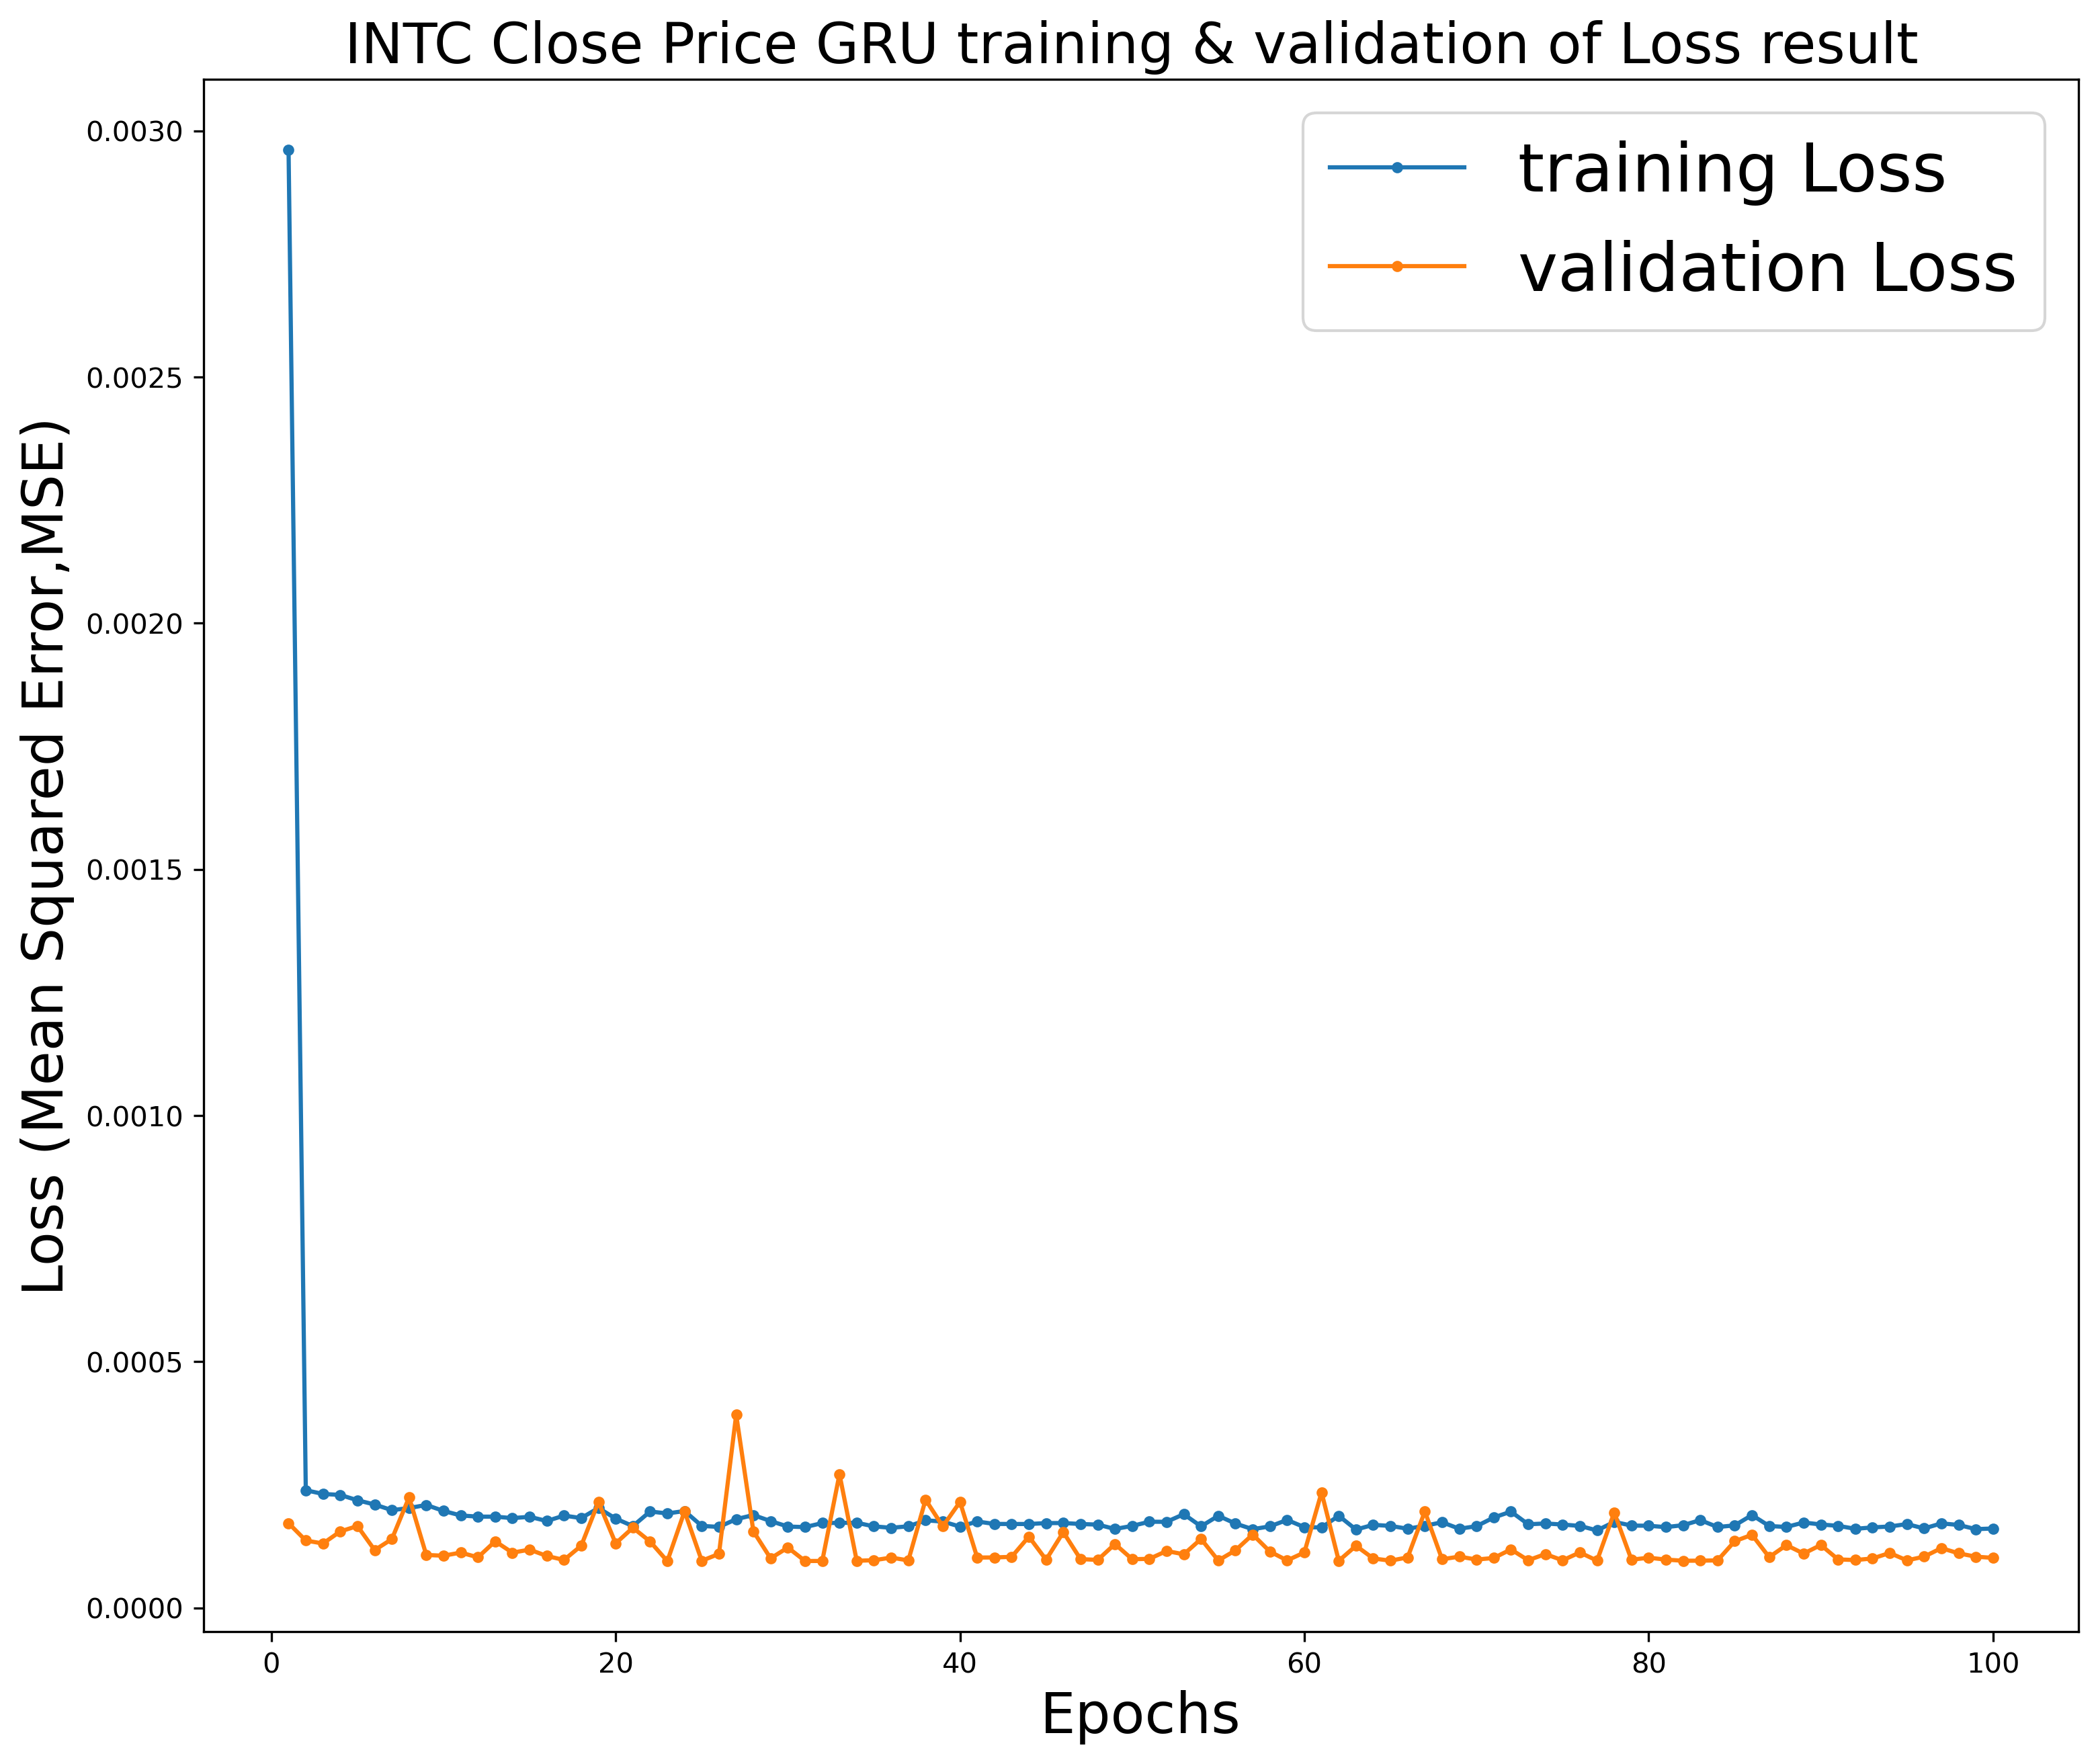

In [ ]:
#Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean Squared Error,MSE)',fontsize=20)
plt.title('INTC Close Price GRU training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

# Testing

In [ ]:

predicted_price = model.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_price = sc.inverse_transform(predicted_price)
actual_price = sc.inverse_transform(y_test)

37/37 [==============================] - 0s 485us/step


In [ ]:
df1 = pd.DataFrame(predicted_price)
df2 = pd.DataFrame(actual_price)

df1.columns = ['Pred']
df2.columns = ['Actual']

merged_df = pd.concat([df1, df2], axis=1)
merged_df.to_csv('output.csv', index=False)

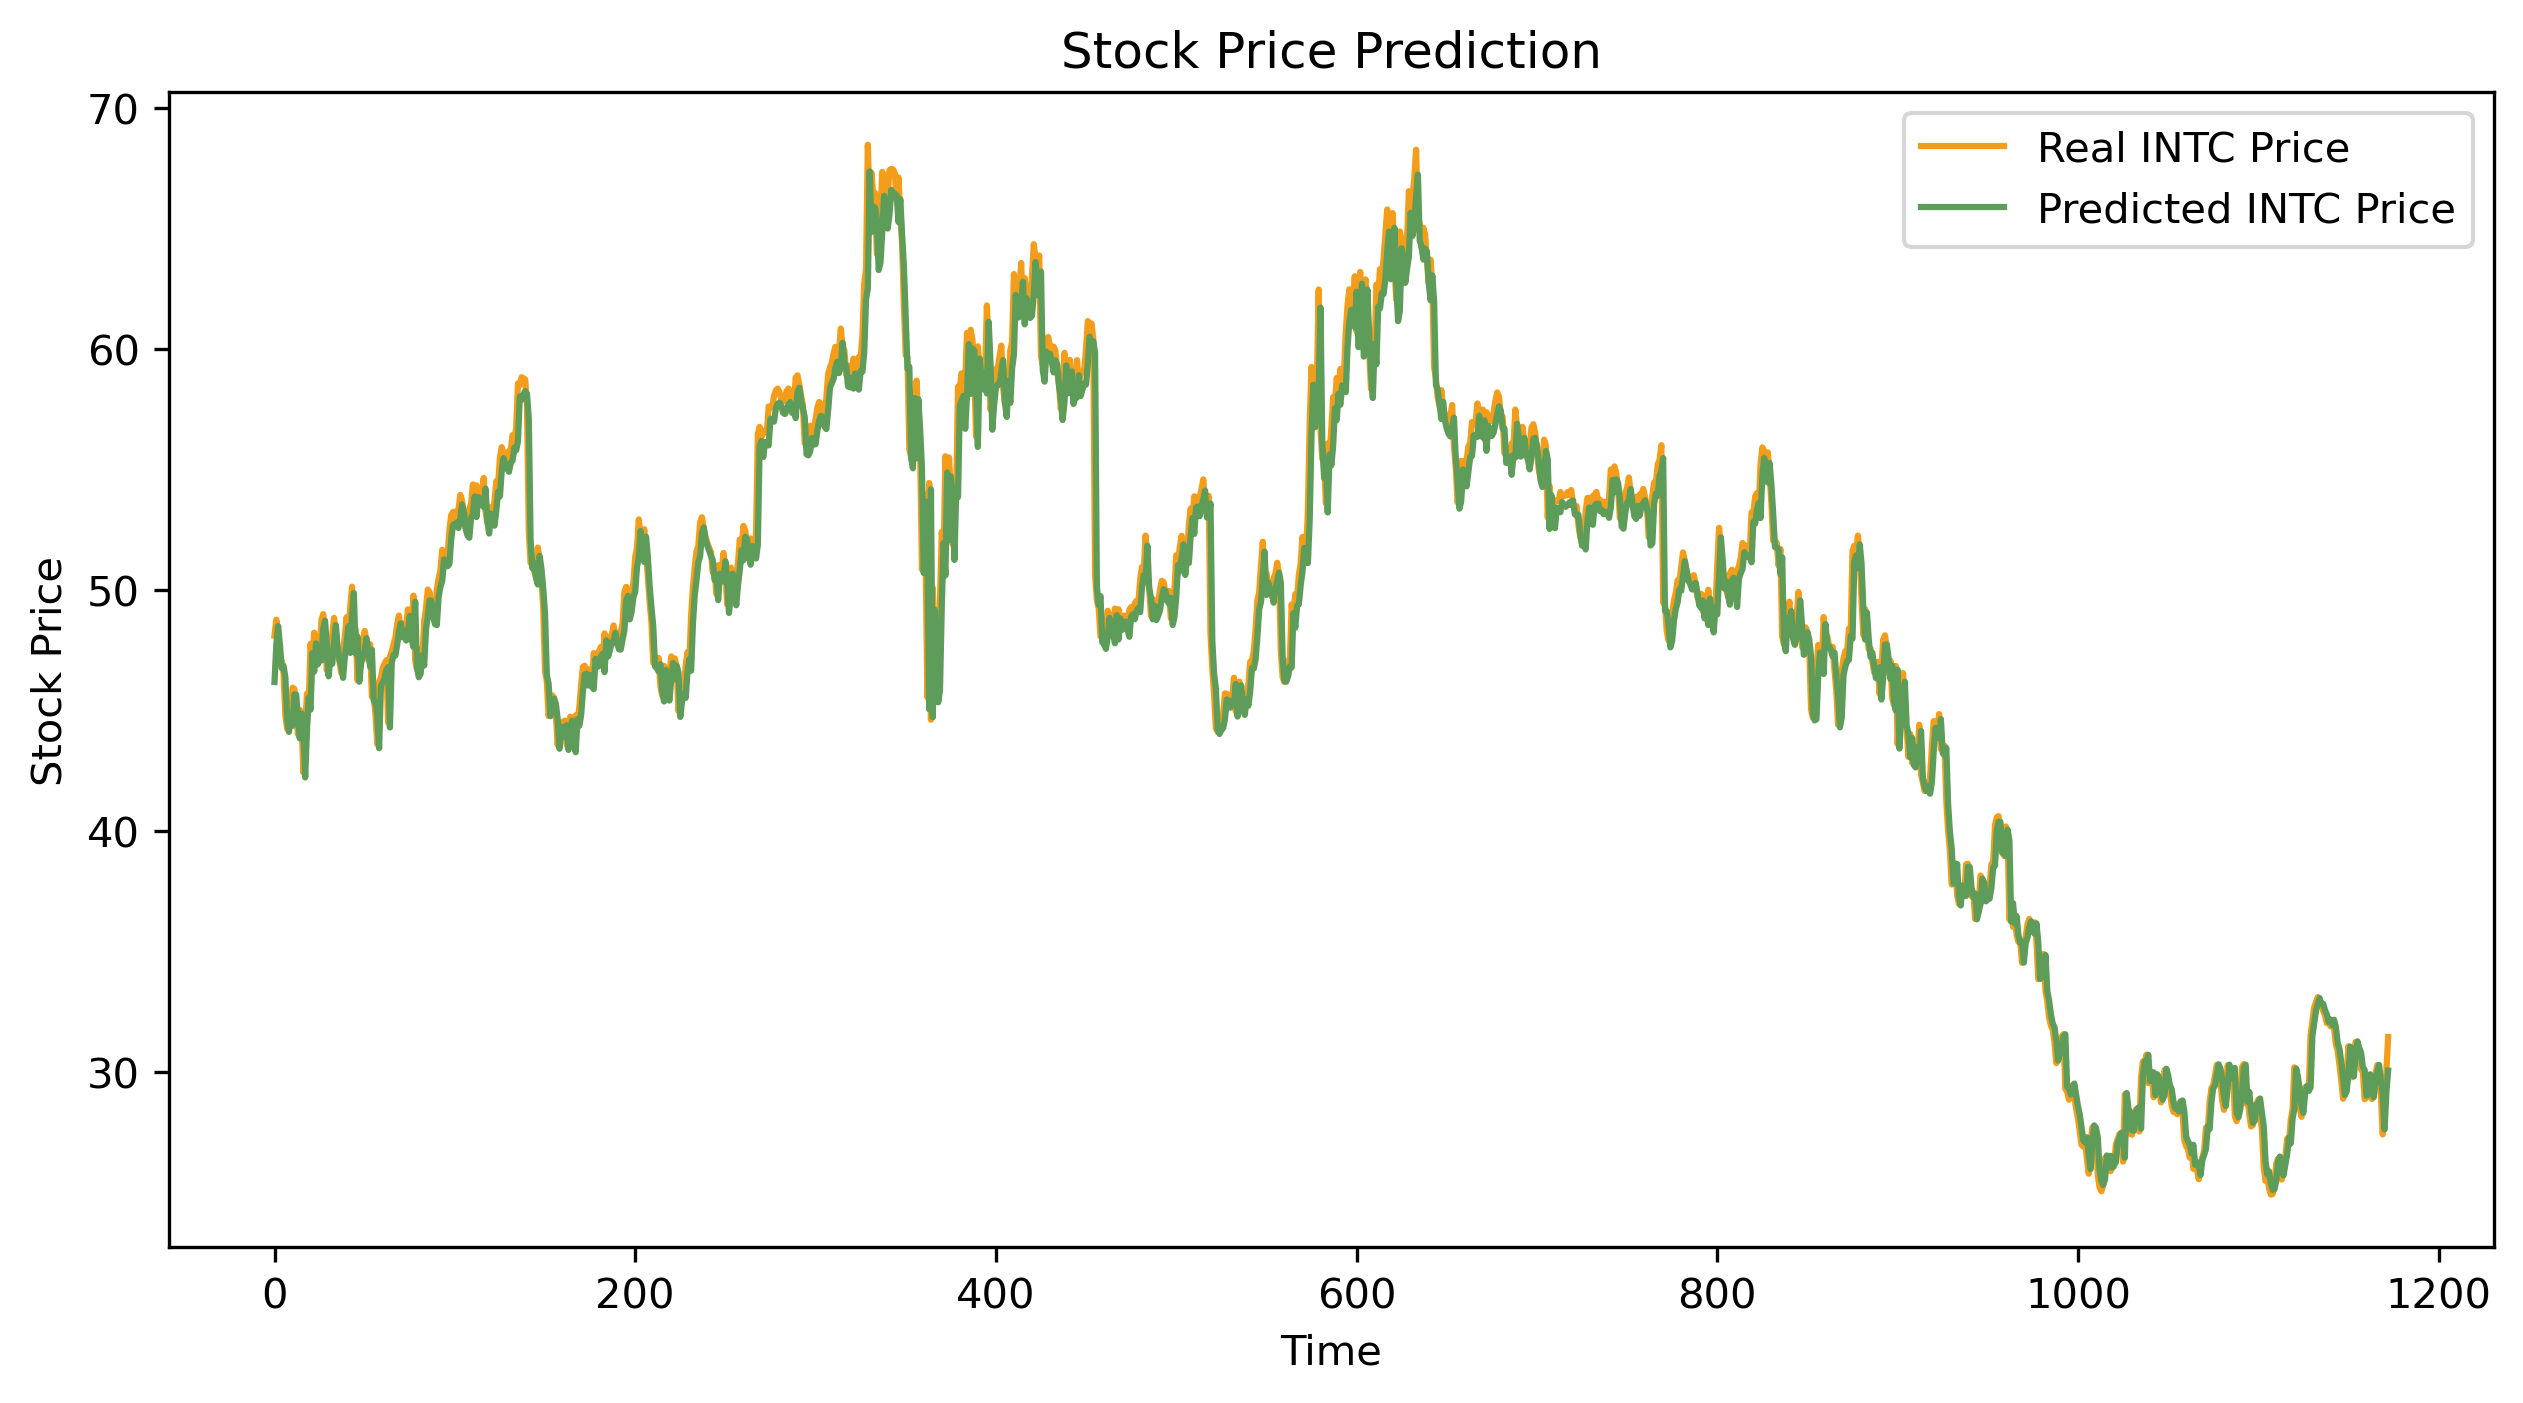

In [ ]:
plt.figure(figsize=(10,5),dpi=300)
plt.plot(actual_price, color = '#F49D1A', label = 'Real INTC Price')
plt.plot(predicted_price, color = '#5D9C59', label = 'Predicted INTC Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Improve the model

## Build model & Compile & Fit

In [ ]:
keras.backend.clear_session()
model = Sequential()
model.add(layers.SimpleRNN(units = 64,return_sequences=True, input_shape = (X_train.shape[1], 1)))
#model.add(LSTM(units = 64,return_sequences=True, input_shape = (X_train.shape[1], 1)))
#model.add(GRU(units = 64,return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
#model.add(Dropout(0.4))
#model.add(GRU(units = 32,activation='relu'))
#model.add(GRU(units = 64,activation='relu'))
model.add(LSTM(units = 32,activation='relu'))
#model.add(LSTM(units = 64,activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(units = 1))
model.summary()
opt=Adam(learning_rate=0.002,beta_1=0.95)
model.compile(optimizer = opt, loss = 'mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 64)             4224      
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,673
Trainable params: 16,673
Non-trainable params: 0
_________________________________________________________________


## Plot the history of training and validation

In [ ]:
history = model.fit(X_train, y_train, epochs = 250, batch_size = 128, validation_data=(X_val,y_val))

Epoch 1/250
30/30 [==============================] - 1s 7ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 2/250
30/30 [==============================] - 0s 3ms/step - loss: 9.5654e-04 - val_loss: 4.4178e-04
Epoch 3/250
30/30 [==============================] - 0s 3ms/step - loss: 6.0548e-04 - val_loss: 4.7151e-04
Epoch 4/250
30/30 [==============================] - 0s 3ms/step - loss: 4.9897e-04 - val_loss: 2.1080e-04
Epoch 5/250
30/30 [==============================] - 0s 3ms/step - loss: 4.9138e-04 - val_loss: 2.7001e-04
Epoch 6/250
30/30 [==============================] - 0s 3ms/step - loss: 4.6367e-04 - val_loss: 2.1797e-04
Epoch 7/250
30/30 [==============================] - 0s 3ms/step - loss: 4.5311e-04 - val_loss: 2.0214e-04
Epoch 8/250
30/30 [==============================] - 0s 3ms/step - loss: 4.6821e-04 - val_loss: 1.7467e-04
Epoch 9/250
30/30 [==============================] - 0s 3ms/step - loss: 4.2972e-04 - val_loss: 1.6839e-04
Epoch 10/250
30/30 [=========================

In [ ]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'val_loss'])

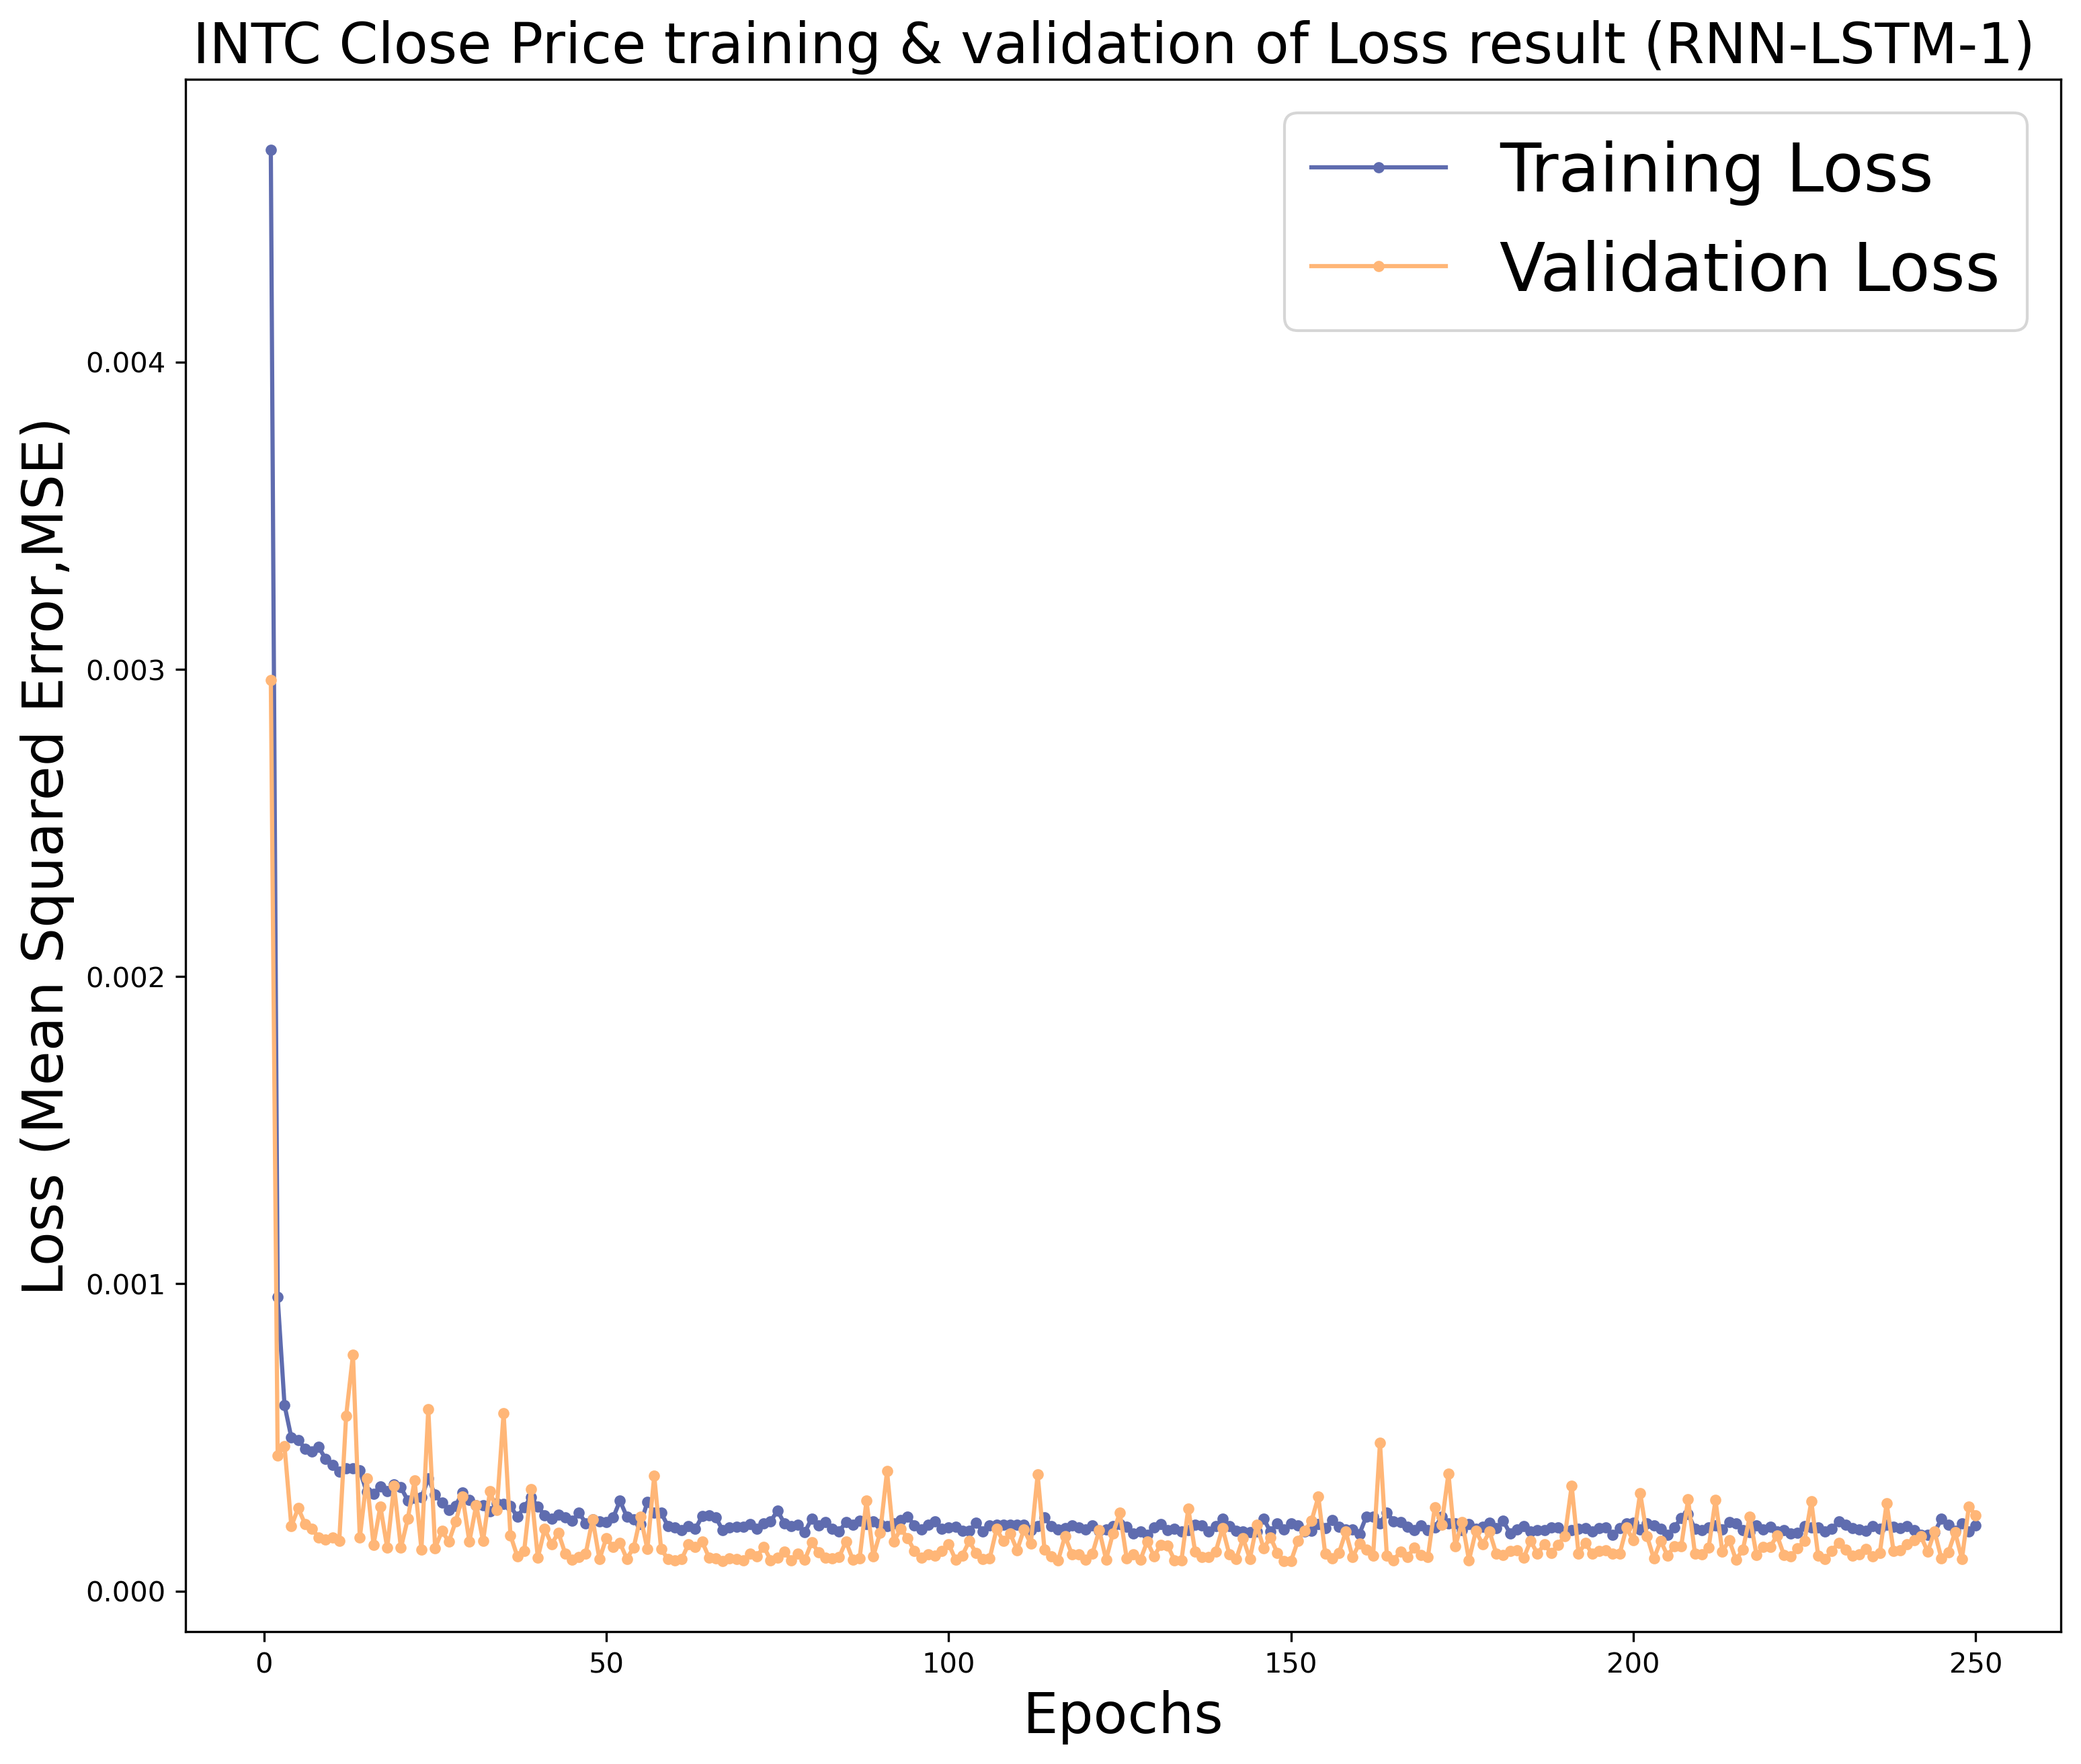

In [ ]:
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean Squared Error,MSE)',fontsize=20)
plt.title('INTC Close Price training & validation of Loss result (RNN-LSTM-1) ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='Training Loss', color = '#5F6CAF')
plt.plot(epochs, val_loss_values,marker='.',label='Validation Loss', color = '#FFB677')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
predicted_price = model.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_price = sc.inverse_transform(predicted_price)
actual_price = sc.inverse_transform(y_test)

37/37 [==============================] - 0s 660us/step


In [ ]:
df1 = pd.DataFrame(predicted_price)
df2 = pd.DataFrame(actual_price)

df1.columns = ['Pred']
df2.columns = ['Actual']

merged_df = pd.concat([df1, df2], axis=1)
merged_df.to_csv('output2.csv', index=False)

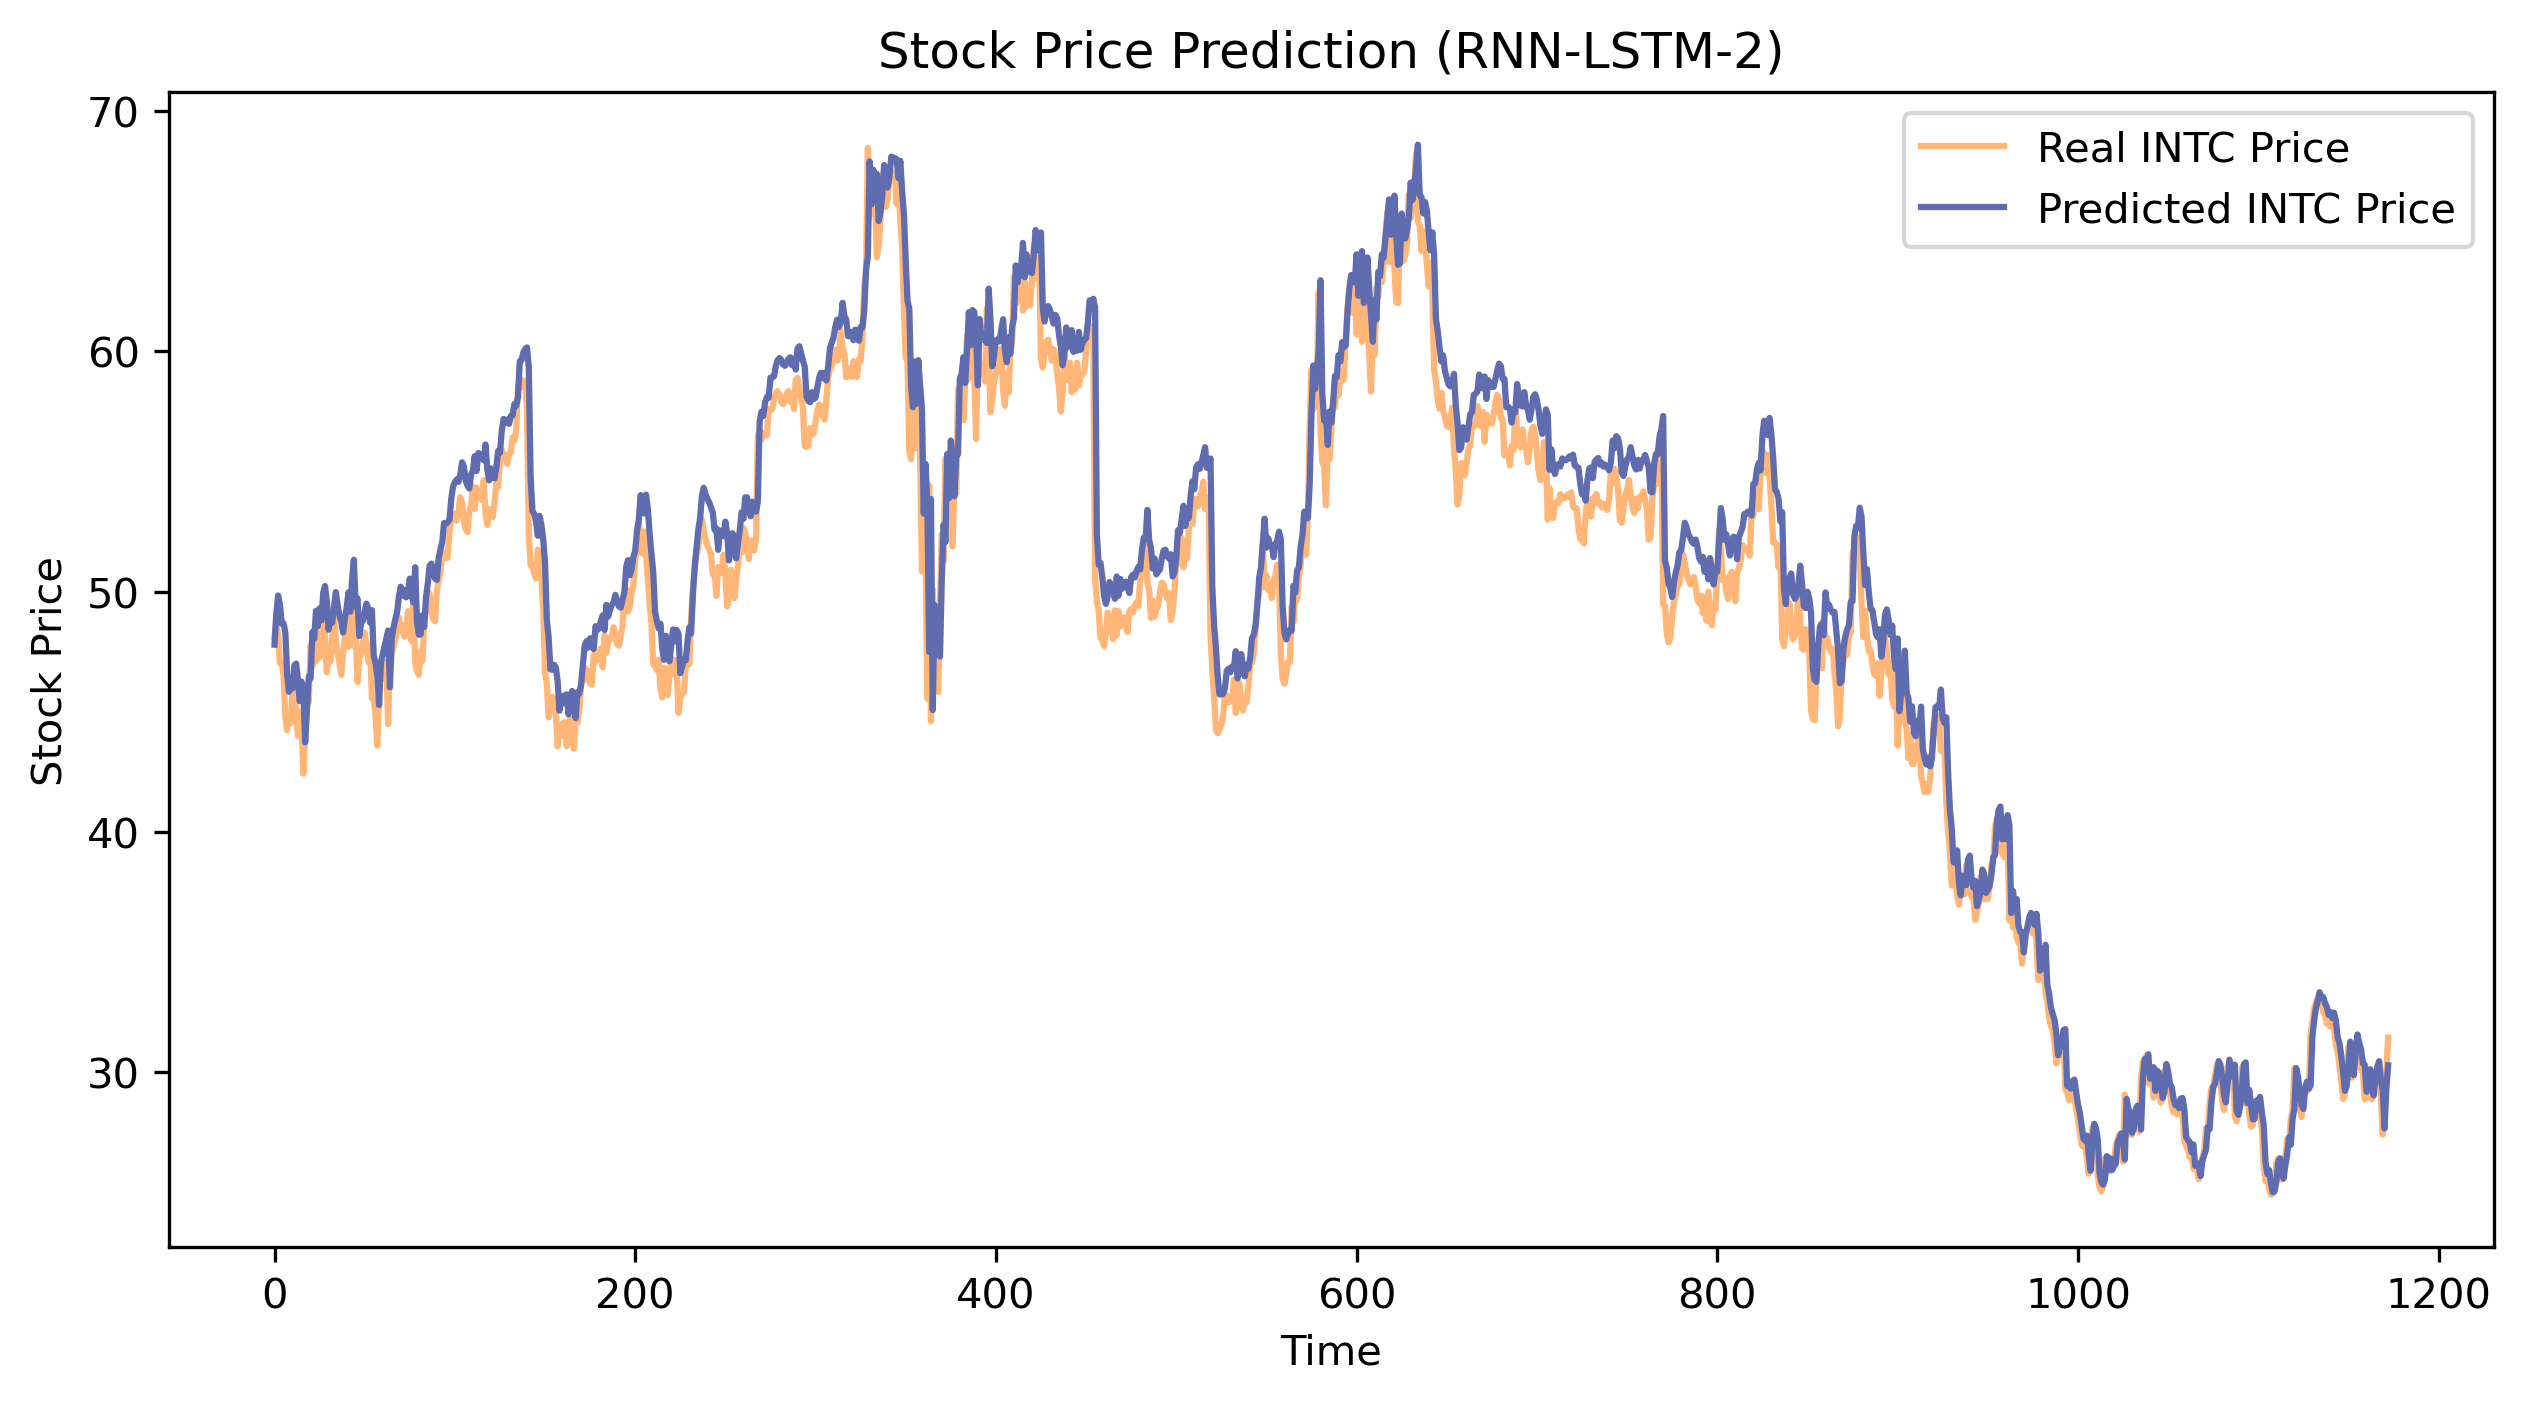

In [ ]:
plt.figure(figsize=(10,5),dpi=300)
plt.plot(actual_price, color = '#FFB677', label = 'Real INTC Price')
plt.plot(predicted_price, color = '#5F6CAF', label = 'Predicted INTC Price')
plt.title('Stock Price Prediction (RNN-LSTM-2)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
predicted_price
actual_price

MAE=mean_absolute_error(actual_price,predicted_price)
MSE=mean_squared_error(actual_price,predicted_price,squared=True)
RMSE=mean_squared_error(actual_price,predicted_price,squared=False)
MAPE=mean_absolute_percentage_error(actual_price,predicted_price)
SMAPE=SMAPE_calulate(actual_price,predicted_price)
RAE=RAE_calculate(actual_price,predicted_price)
MRAE=MRAE_calculate(actual_price,predicted_price)
MdRAE=MdRAE_calculate(actual_price,predicted_price)
RSE=RSE_calculate(actual_price,predicted_price,Root=False)
RRSE=RSE_calculate(actual_price,predicted_price,Root=True)

print('MAE:',round(MAE,3)) # Mean Absolute Error 平均絕對誤差
print('MSE:',round(MSE,3)) # Mean Square Error 均方誤差
print('RMSE:',round(RMSE,3)) # Root Mean Squared Error 均方根誤差
print('MAPE:',round(MAPE*100,3),'%') # Mean Absolute Percentage Error 平均絕對百分誤差
print('SMAPE:',round(SMAPE,3),'%') # Symmetric Mean Absolute Percentage Error 對稱性平均絕對百分比誤差
print('RAE:',round(RAE,3)) # Relative Absolute Error 相對絕對誤差
print('MRAE:',MRAE) # Mean Relative Absolute Error
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value

print('RSE:',round(RSE,3)) # Relative Squared Error 相對平方誤差
print('RRSE:',round(RRSE,3))

MAE: 1.387
MSE: 3.106
RMSE: 1.762
MAPE: 2.858 %
SMAPE: 2.805 %
RAE: 0.17
MRAE: 0.00014475777654086874
MdRAE: 0.214 bench: 48.175
RSE: 0.028
RRSE: 0.167
